# E-commerce Orders – Exploratory Data Analysis (EDA)

IN this notebook we explore the synthetic e-commerce dataset loaded into our PostgreSQL warehouse.

We will:
- Inspect data quality and basic distributions.
- Analyze revenue over time and by category.
- Look at customer behavior and lifetime value.
- Explore product performance.
- Summarize key insights.

Imports & Connection to DB:

In [1]:
import os

import pandas as pd
import psycopg2
from dotenv import load_dotenv

load_dotenv()

POSTGRES_HOST = os.getenv("POSTGRES_HOST", "localhost")
POSTGRES_PORT = os.getenv("POSTGRES_PORT", "5432")
POSTGRES_DB = os.getenv("POSTGRES_DB", "de_db")
POSTGRES_USER = os.getenv("POSTGRES_USER", "de_user")
POSTGRES_PASSWORD = os.getenv("POSTGRES_PASSWORD", "de_password")

conn = psycopg2.connect(
    host=POSTGRES_HOST,
    port=POSTGRES_PORT,
    dbname=POSTGRES_DB,
    user=POSTGRES_USER,
    password=POSTGRES_PASSWORD,
)


We will use `staging.orders_stg` as the main fact table.

In [2]:
query = """
SELECT *
FROM staging.orders_stg;
"""
orders = pd.read_sql(query, conn)
orders.head()


/var/folders/1y/5w4zxjx128d3d0wxw2vv78v00000gn/T/ipykernel_33801/313510884.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders = pd.read_sql(query, conn)


,order_id,order_timestamp,customer_id,product_id,category,price,quantity,status,total_amount
0,1,2024-03-07 05:23:48,4803,167,electronics,988.29,9,delivered,8894.61
1,2,2024-11-23 00:39:09,4444,57,fashion,296.68,9,delivered,2670.12
2,3,2025-01-24 19:26:47,1627,210,books,62.31,5,delivered,311.55
3,4,2024-12-19 13:22:07,3153,43,home,1892.07,7,delivered,13244.49
4,5,2024-05-30 07:30:55,3627,59,home,2597.53,7,delivered,18182.71


### 1. Basic Structure & Sanity Checks

In [3]:
orders.shape

(10000, 9)

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   order_id         10000 non-null  int64         
 1   order_timestamp  10000 non-null  datetime64[ns]
 2   customer_id      10000 non-null  int64         
 3   product_id       10000 non-null  int64         
 4   category         10000 non-null  object        
 5   price            10000 non-null  float64       
 6   quantity         10000 non-null  int64         
 7   status           10000 non-null  object        
 8   total_amount     10000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 703.2+ KB


In [5]:
orders.describe()

,order_id,order_timestamp,customer_id,product_id,price,quantity,total_amount
count,10000.00000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2024-06-03 08:46:35.276000,2513.968200,149.460500,576.493253,5.467100,3129.520215
min,1.00000,2023-01-01 00:10:04,1.000000,1.000000,6.040000,1.000000,6.040000
25%,2500.75000,2023-09-20 16:47:32.500000,1268.000000,75.000000,60.875000,3.000000,302.085000
50%,5000.50000,2024-06-04 06:05:52.500000,2516.000000,148.000000,279.295000,5.000000,1197.235000
75%,7500.25000,2025-02-14 23:22:22.750000128,3769.000000,224.000000,784.050000,8.000000,3611.262500
max,10000.00000,2025-11-01 17:25:33,5000.000000,300.000000,2999.070000,10.000000,29839.800000
std,2886.89568,NaN,1442.082996,86.507913,733.690430,2.867462,4792.080092


In [6]:
orders.isna().sum()

order_id           0
order_timestamp    0
customer_id        0
product_id         0
category           0
price              0
quantity           0
status             0
total_amount       0
dtype: int64

**Observations:**
- No unexpected NULLs (especially in `order_id`, `order_timestamp`, `customer_id`, `total_amount`). 
- `price` and `quantity` distributions look reasonable, always positive.


## 2. Distributions: Status, Category, Time Range

In [7]:
orders["status"].value_counts()

status
delivered    7413
shipped      1590
pending       789
cancelled     208
Name: count, dtype: int64

In [8]:
orders["category"].value_counts()

category
electronics    2549
home           2525
books          2465
fashion        2461
Name: count, dtype: int64

In [9]:
orders["order_timestamp"].min(), orders["order_timestamp"].max()

(Timestamp('2023-01-01 00:10:04'), Timestamp('2025-11-01 17:25:33'))

## 3. Revenue Over Time

In [10]:
orders["order_date"] = pd.to_datetime(orders["order_timestamp"]).dt.date
daily_revenue = (
    orders.groupby("order_date")["total_amount"].sum().reset_index().sort_values("order_date")
)
daily_revenue.head()

,order_date,total_amount
0,2023-01-01,42060.87
1,2023-01-02,56065.61
2,2023-01-03,5640.31
3,2023-01-04,12042.88
4,2023-01-05,29099.54


<Axes: title={'center': 'Daily Revenue Over Time'}, xlabel='order_date'>

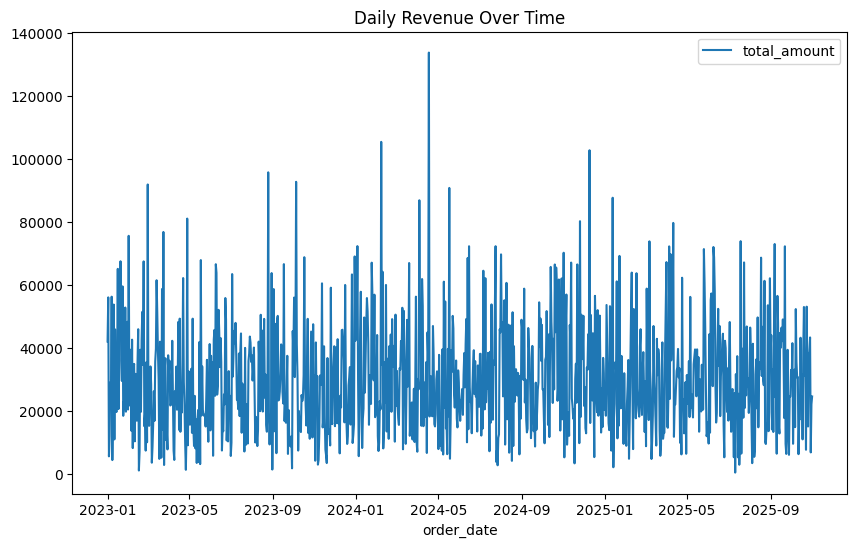

In [11]:
daily_revenue.plot(x="order_date", y="total_amount", title="Daily Revenue Over Time", figsize=(10, 6))

## 4. Revenue by Category

In [12]:
category_revenue = (
    orders.groupby("category")["total_amount"]
    .agg(["count", "sum", "mean"])
    .rename(columns={ "count": "order_count","sum": "total_revenue","mean": "average_order_value"})
    .sort_values("total_revenue", ascending=False)
)
category_revenue

,order_count,total_revenue,average_order_value
category,,,
home,2525,20616300.05,8164.871307
electronics,2549,7373330.59,2892.636559
fashion,2461,2781736.66,1130.327777
books,2465,523834.85,212.509067


**Notes:**
- All Categories have around the same order volume (order_count)
- the Home category brings the most revenue with 20616300.05 Total Revenue, this category wins by price as items are generally more expensive than items in other categories

## 5. Customer Lifetime Value (LTV)

In [13]:
customer_ltv = pd.read_sql("""
    SELECT *
    FROM mart.customer_ltv;
""", conn)

customer_ltv.describe()

/var/folders/1y/5w4zxjx128d3d0wxw2vv78v00000gn/T/ipykernel_33801/1497015229.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  customer_ltv = pd.read_sql("""


,customer_id,lifetime_value
count,4310.000000,4310.000000
mean,2503.336891,7261.067784
std,1440.689825,8285.806081
min,1.000000,9.630000
25%,1264.500000,1246.285000
50%,2509.500000,4175.975000
75%,3751.750000,10336.215000
max,5000.000000,62736.520000


<Axes: title={'center': 'Customer Lifetime Value Distribution'}, ylabel='Frequency'>

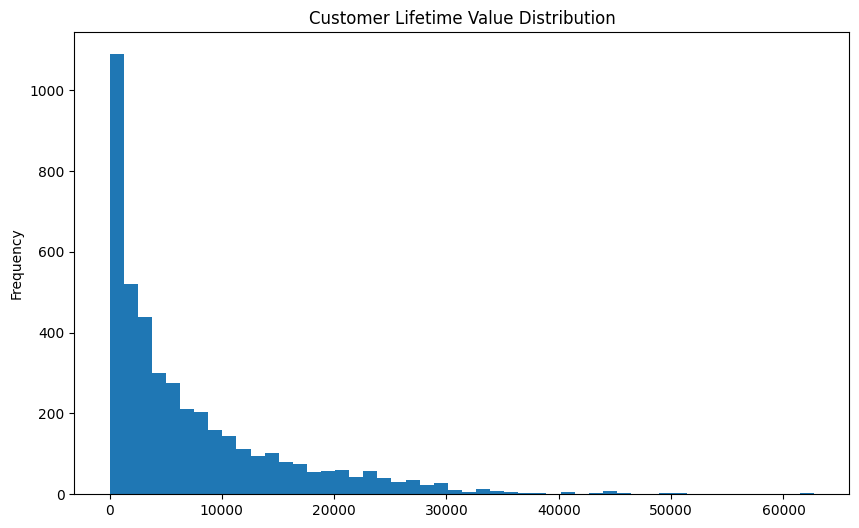

In [14]:
customer_ltv["lifetime_value"].plot.hist(bins=50, title="Customer Lifetime Value Distribution", figsize=(10, 6))

In [15]:
customer_ltv.sort_values("lifetime_value", ascending=False).head(10)

,customer_id,lifetime_value
163,2150,62736.52
3550,3597,62607.80
2073,516,58789.17
2843,4843,57016.28
3700,1901,54609.97
4293,3510,51277.98
2011,3881,50869.75
472,4420,50701.13
1197,1619,49905.41
1703,2101,49603.96


In [16]:
# Median LTV
customer_ltv.sort_values("lifetime_value", ascending=False).median()["lifetime_value"]

np.float64(4175.975)

The lifetime value distribution shows a long-tail pattern typical for e-commerce: a small portion of customers generates significantly more revenue than typical customer. 
The median LTV is about 4.2k, while the highest customers exceed 62k, representing more than 93% more value. This indicates strong differentiation in customer behavior and supports segmentation into VIP. High, Medium, and Low groups.


## 6. Repeat Purchase Behavior

In [17]:
customer_orders = (
    orders.groupby("customer_id")["order_id"].nunique().reset_index(name="order_count")
)

customer_orders.head()

,customer_id,order_count
0,1,2
1,2,1
2,5,1
3,6,1
4,7,1


In [18]:
one_time_buyers = customer_orders[customer_orders["order_count"] == 1]
one_time_buyers.shape[0]

1329

In [19]:
pct_one_time_buyers = (one_time_buyers.shape[0] / customer_orders.shape[0]) * 100
pct_one_time_buyers

30.83526682134571

One-time buyer rate is around 31%

## 7. Product performance

In [20]:
product_performance = (
    orders.groupby(["product_id", "category"])["total_amount"]
    .agg(["count", "sum", "mean"])
    .rename(columns={ "count": "order_count","sum": "revenue","mean": "average_order_value"})
    .sort_values("revenue", ascending=False)
    )

product_performance.head(10)

,,order_count,revenue,average_order_value
product_id,category,,,
105,home,17,156805.57,9223.857059
218,home,13,148879.01,11452.231538
127,home,12,136176.25,11348.020833
93,home,14,130926.83,9351.916429
151,home,11,129673.14,11788.467273
7,home,15,126550.70,8436.713333
274,home,13,126494.71,9730.362308
281,home,14,125298.48,8949.891429
97,home,11,124742.22,11340.201818


## 8. Order Status & Operational view

In [21]:
status_by_day = (
    orders.groupby(["order_date", "status"])["order_id"]
    .count()
    .reset_index(name="order_count")
    .sort_values(["order_date", "status"])
)
status_by_day.head()

cancellations_by_day = status_by_day[status_by_day["status"] == "cancelled"].sort_values("order_count", ascending=False)
cancellations_by_day.describe()

,order_count
count,191.000000
mean,1.089005
std,0.336287
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,4.000000


In [22]:
# Highest cancellation rates by day
daily_counts = orders.groupby("order_date")["order_id"].count().reset_index(name="daily_order_count")
daily_cancellations = orders[orders["status"]=="cancelled"].groupby("order_date")["order_id"].count().reset_index(name="daily_cancellation_count")

daily_cancellation_rates = daily_counts.merge(daily_cancellations, on="order_date", how="left")
daily_cancellation_rates["daily_cancellation_count"] = daily_cancellation_rates["daily_cancellation_count"].fillna(0)
daily_cancellation_rates["cancellation_rate"] = daily_cancellation_rates["daily_cancellation_count"] / daily_cancellation_rates["daily_order_count"] * 100
daily_cancellation_rates.sort_values("cancellation_rate", ascending=False).head(10)

,order_date,daily_order_count,daily_cancellation_count,cancellation_rate
486,2024-05-01,5,2.0,40.000000
267,2023-09-25,3,1.0,33.333333
1021,2025-10-18,7,2.0,28.571429
359,2023-12-26,14,4.0,28.571429
773,2025-02-12,8,2.0,25.000000
503,2024-05-18,9,2.0,22.222222
835,2025-04-15,9,2.0,22.222222
516,2024-05-31,9,2.0,22.222222
427,2024-03-03,9,2.0,22.222222
58,2023-02-28,5,1.0,20.000000


## 9. Summary and Key Insights

This EDA validates that the end-to-end pipeline is producing clean, analyable data and that the warehouse models (raw -> staging -> mart) are functioning as intended and support a typical e-commerce analytics workflow.

- **Data Quality**:

    - No unexpected NULLs in key fields (order_id, order_timestamp, customer_id, total_amount).  
    - Price and quantity distributions are within expected ranges from the generator.

- **Analytical Insights**:

Even with generated data, we can observe realistic behavioral patterns:

- Revenue trends show natural fluctuations and spikes, validating the timestamp generation logic.
- The **Home category** appears to be most profitable due to higher typical prices.
- LTV distribution is highly skewed, a small number of customers generate disproportionately high value (top customers > 60k LTV vs a ~4.2k median).
- Around **31% of customers are one-time buyers**, a realistic figure for most retail businesses.
- Cancellation rates fluctuate by day, reaching up to 40% on certain dates.

### Next Steps and Enhancements
- RFM segmentation to improve customer insights
- Analysis for customer retention
- A/B experiment simulation (example: discount impact)
- Anomaly detection in cancellations and refunds
- Extend the pipeline to S3 + Redshift
- Build dashboards (example: Tableau) on top of the marts
